In [80]:
# Create GAN for MDP process with two states

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tcn import TCN, tcn_full_summary


class GAN:
    def __init__(self, seq_len=16, latent_dim=25):
        # self.P = np.random.uniform(0, 1, (6, 6))
        # print(self.P, np.sum(self.P, axis=1, keepdims=True))
        # self.P = self.P / np.sum(self.P, axis=1, keepdims=True)
        self.states = [0, 1]
        self.actions = [0, 1, 2]
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        # print(self.P)
        self.build_generator()
        self.build_discriminator()
        self.build_gan()
        # print(self.P)

    def generate_real_samples(self, n_samples):
        X_total = []
        labels = []
        for i in range(n_samples):
            current_state = 0
            policy = np.array(self.select_policy())
            labels.append(policy)
            X = []
            while len(X) < self.seq_len:
                if current_state == 0:
                    action = np.random.choice([0, 1], p=policy)
                    if action == 0:
                        next_state = np.random.choice([0, 1])
                        if next_state == 0:
                            reward = 5
                        else:
                            reward = 5
                    else:
                        next_state = 1
                        reward = 10
                else:
                    action = 2
                    next_state = 1
                    reward = -1
                current_state_cat = tf.keras.utils.to_categorical(
                    current_state, num_classes=2
                )
                action_cat = tf.keras.utils.to_categorical(action, num_classes=3)
                reward = (reward + 1) / 11
                X.append(np.concatenate([current_state_cat, action_cat, [reward]]))
                current_state = next_state

            X = np.array(X)
            # X = tf.keras.utils.to_categorical(X, num_classes=6)
            X_total.append(X)
        X = np.array(X_total)
        y = np.ones((n_samples, 1)) * 0.9
        # print(X.shape, y.shape)
        # labels = tf.keras.utils.to_categorical(labels, num_classes=4)
        labels = np.array(labels)
        return X, labels, y

    def select_policy(self):
        if np.random.uniform() < 0.1:
            if np.random.uniform() <= 0.5:
                policy = [1.0, 0.0]
            else:
                policy = [0.0, 1.0]
        else:
            policy = np.random.uniform(0, 1, 2)
            policy = policy / np.sum(policy)
        return policy

    def generate_fake_samples(self, n_samples, labels):
        X = self.generator.predict([np.random.normal(0, 1, (n_samples, 25)), labels])
        y = np.zeros((n_samples, 1))
        return X, y

    def calculate_P(self, n_samples, labels):

        X, _ = self.generate_fake_samples(n_samples, labels)
        X1 = np.argmax(X[:, :, :2], axis=2)
        X2 = np.argmax(X[:, :, 2:5], axis=2)
        X3 = X[:, :, 5]
        # X1 = np.argmax(X1, axis=1)
        # X2 = np.argmax(X2, axis=1)
        print("Probabilitity of starting position being 0:", np.mean(X1[:, 0] == 0))
        print("Probabilitity of starting position being 1:", np.mean(X1[:, 0] == 1))

        print(
            "Probability of action 0 being taken in state 0:", np.mean(X2[X1 == 0] == 0)
        )
        print(
            "Probability of action 1 being taken in state 0:", np.mean(X2[X1 == 0] == 1)
        )
        print(
            "Probability of action 2 being taken in state 1:", np.mean(X2[X1 == 1] == 2)
        )

    def calculate_final_P(self, n_samples, labels):
        X, _ = self.generate_fake_samples(n_samples, labels)
        X1 = np.argmax(X[:, :, :2], axis=2)
        X2 = np.argmax(X[:, :, 2:5], axis=2)
        X3 = X[:, :, 5]
        # X1 = np.argmax(X1, axis=1)
        # X2 = np.argmax(X2, axis=1)
        print("Probabilitity of starting position being 0:", np.mean(X1[:, 0] == 0))
        print("Probabilitity of starting position being 1:", np.mean(X1[:, 0] == 1))

        print(
            "Probability of action 0 being taken in state 0:", np.mean(X2[X1 == 0] == 0)
        )
        print(
            "Probability of action 1 being taken in state 0:", np.mean(X2[X1 == 0] == 1)
        )
        print(
            "Probability of action 2 being taken in state 1:", np.mean(X2[X1 == 1] == 2)
        )
        ps = np.zeros((2, 3, 2))
        for i in range(n_samples):
            for j in range(self.seq_len - 1):
                ps[X1[i, j], X2[i, j], X1[i, j + 1]] += 1
        ps = ps / np.sum(ps, axis=2, keepdims=True)
        print(ps)

    # def calculate_P_real(self, n_samples):
    #     X, _ = self.generate_real_samples(n_samples)
    #     X = np.argmax(X, axis=2)
    #     P = np.zeros((6, 6))
    #     for i in range(n_samples):
    #         for j in range(self.seq_len - 1):
    #             P[X[i, j], X[i, j + 1]] += 1

    #     P = P / np.sum(P, axis=1, keepdims=True)
    #     return P

    def build_generator(self):
        # tcn_layer1 = TCN(nb_filters=500, dilations=(1,), return_sequences=True)

        # print(tcn_layer1.receptive_field)
        inp = tf.keras.layers.Input(shape=(self.latent_dim,))
        inp2 = tf.keras.layers.Input(shape=(2,))
        # inp2
        # tmp = tf.keras.layers.Embedding(4, 4)(inp2)
        inp3 = tf.keras.layers.Concatenate()([inp, inp2])
        x = tf.keras.layers.Dense(16 * 3000)(inp3)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Reshape((16, 3000))(x)
        
        y1 = tf.keras.layers.Dense(2, activation="softmax")(x) # State

        x = concat(x,y1)
        
        y2 = tf.keras.layers.Dense(3, activation="softmax")(x) # Action

        
        
        y3 = tf.keras.layers.Dense(1, activation="sigmoid")(x) # Reward
        
        y = tf.keras.layers.Concatenate()([y1, y2, y3])
        self.generator = tf.keras.models.Model(inputs=[inp, inp2], outputs=y)
        # self.generator = tf.keras.models.Sequential(
        #     [
        #         tf.keras.layers.Dense(4 * 2000, input_shape=(25,)),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Reshape((4, 2000)),
        #         tf.keras.layers.Conv1DTranspose(100, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1DTranspose(50, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1DTranspose(
        #             5, 3, strides=1, padding="same", activation="sigmoid"
        #         ),
        #     ]
        # )
        # inp = tf.keras.layers.Input(shape=(25,))
        # x = self.generator(inp)
        # y1 = tf.keras.layers.Conv1DTranspose(
        #     2, 3, strides=1, padding="same", activation="softmax"
        # )(x)
        # y2 = tf.keras.layers.Conv1DTranspose(
        #     3, 3, strides=1, padding="same", activation="softmax"
        # )(x)
        # y = tf.keras.layers.Concatenate()([y1, y2])
        # self.generator = tf.keras.models.Model(inputs=inp, outputs=y)

    def summarize_generator(self):
        self.generator.summary()
        # tf.keras.utils.plot_model(self.generator, show_shapes=True, dpi=64)

    def build_discriminator(self):
        # tcn_layer2 = TCN(nb_filters=500, dilations=(1, 2), return_sequences=False)
        # self.discriminator = tf.keras.models.Sequential(
        #     [
        #         tf.keras.layers.Input(shape=(self.seq_len, 13)),
        #         # tcn_layer2,
        #         tf.keras.layers.Flatten(),
        #         tf.keras.layers.Dense(10000, activation="relu"),
        #         tf.keras.layers.Dense(1, activation="sigmoid"),
        #     ]
        # )
        inp = tf.keras.layers.Input(shape=(self.seq_len, 6))
        inp2 = tf.keras.layers.Input(shape=(2,))
        x = tf.keras.layers.Flatten()(inp)
        x = tf.keras.layers.Concatenate()([x, inp2])
        x = tf.keras.layers.Dense(10000, activation="relu")(x)
        y = tf.keras.layers.Dense(1, activation="sigmoid")(x)
        self.discriminator = tf.keras.models.Model(inputs=[inp, inp2], outputs=y)
        # self.discriminator = tf.keras.models.Sequential(
        #     [
        #         tf.keras.layers.Conv1D(
        #             50, 3, strides=2, padding="same", input_shape=(self.seq_len, 5)
        #         ),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1D(100, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1D(200, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Flatten(),
        #         tf.keras.layers.Dense(1, activation="sigmoid"),
        #     ]
        # )
        self.discriminator.compile(
            loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5),
            # optimizer="adam",
            metrics=["accuracy"],
        )

    def summarize_discriminator(self):
        self.discriminator.summary()
        # tf.keras.utils.plot_model(self.discriminator, show_shapes=True, dpi=64)

    def build_gan(self):
        self.discriminator.trainable = False
        # self.gan = tf.keras.models.Sequential(
        #     [
        #         self.generator,
        #         self.discriminator,
        #     ]
        # )
        latent_input, label_input = self.generator.input
        output = self.discriminator([self.generator.output, label_input])
        self.gan = tf.keras.models.Model(
            inputs=[latent_input, label_input], outputs=output
        )
        self.gan.compile(
            loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5),
        )

    def show_episode(self, x):
        x1 = np.argmax(x[:, :2], axis=1)
        x2 = np.argmax(x[:, 2:5], axis=1)
        x3 = x[:, 5]
        for i in range(self.seq_len):
            print("State:", x1[i], "Action:", x2[i], "Reward:", np.rint((x3[i] * 11) - 1))

    def train(self, epochs=10, batch_size=128, data_size=10000):
        l1_hist = []
        l2_hist = []
        l3_hist = []
        ac1_hist = []
        ac2_hist = []
        total = data_size // batch_size
        train_data_x, train_labels, train_data_y = self.generate_real_samples(data_size)
        # X1 = np.argmax(train_data_x[:, :, :2], axis=2)
        # X2 = np.argmax(train_data_x[:, :, 2:], axis=2)
        # print("Probabilitity of starting position being 1:", np.mean(X1[:, 0] == 1))
        # print(
        #     "Probability of action 0 being taken in state 0:", np.mean(X2[X1 == 0] == 0)
        # )
        # print(
        #     "Probability of action 1 being taken in state 0:", np.mean(X2[X1 == 0] == 1)
        # )
        # print(
        #     "Probability of action 2 being taken in state 1:", np.mean(X2[X1 == 1] == 2)
        # )
        for i in range(epochs):
            print("Iteration:", i)
            # Train the discriminator
`
            for k in range(total):
                print(k, "/", total, end="\r")
                idx = np.random.randint(0, data_size, batch_size // 2)
                X_real, label_real, y_real = (
                    train_data_x[idx],
                    train_labels[idx],
                    train_data_y[idx],
                )
                if np.random.uniform(0, 1) < 0.1:
                    if np.random.uniform() <= 0.5:
                        fake_labels = [[1, 0] for _ in range(batch_size // 2)]
                    else:
                        fake_labels = [[0, 1] for _ in range(batch_size // 2)]
                else:

                    fake_labels = np.random.uniform(0, 1, (batch_size // 2, 2))
                    fake_labels = fake_labels / np.sum(
                        fake_labels, axis=1, keepdims=True
                    )
                fake_labels = np.array(fake_labels)

                X_fake, y_fake = self.generate_fake_samples(
                    batch_size // 2, fake_labels
                )

                l1, ac1 = self.discriminator.train_on_batch(
                    [X_real, label_real], y_real
                )
                l2, ac2 = self.discriminator.train_on_batch(
                    [X_fake, fake_labels], y_fake
                )

                X_fake = np.random.normal(0, 1, (batch_size, self.latent_dim))
                y_fake = np.ones((batch_size, 1))
                if np.random.uniform(0, 1) < 0.1:
                    if np.random.uniform() <= 0.5:
                        fake_labels = [[1, 0] for _ in range(batch_size)]
                    else:
                        fake_labels = [[0, 1] for _ in range(batch_size)]
                else:
                    fake_labels = np.random.uniform(0, 1, (batch_size, 2))
                    fake_labels = fake_labels / np.sum(
                        fake_labels, axis=1, keepdims=True
                    )
                fake_labels = np.array(fake_labels)
                l3 = self.gan.train_on_batch([X_fake, fake_labels], y_fake)

                l1_hist.append(l1)
                l2_hist.append(l2)
                l3_hist.append(l3)
                ac1_hist.append(ac1)
                ac2_hist.append(ac2)

            # Show plots of the losses and accuracies
            tmp = np.random.uniform(0, 1, 2)
            tmp = tmp / np.sum(tmp)
            fake_labels = np.array([tmp for _ in range(10000)])
            print("For Policy ", tmp)
            calc_p = self.calculate_P(10000, fake_labels)
            # print(calc_p)
            # pred = gan.generator.predict(np.random.normal(0, 1, (1, gan.latent_dim)))
            # print(pred)
            # print(gan.discriminator.predict(pred))
            # print("Loss:",np.mean(np.abs(calc_p - (self.P))))
            if i % 10 >= 0:
                plt.figure(figsize=(10, 10))
                plt.subplot(2, 1, 1)
                plt.plot(l1_hist, label="Discriminator(Real)")
                plt.plot(l2_hist, label="Discriminator(Fake)")
                plt.plot(l3_hist, label="Generator")
                plt.legend()
                plt.title("Losses")
                plt.subplot(2, 1, 2)
                plt.plot(ac1_hist, label="Accuracy(Real)")
                plt.plot(ac2_hist, label="Accuracy(fake)")
                plt.legend()
                plt.title("Accuracies")
                plt.show()
                l1_hist = []
                l2_hist = []
                l3_hist = []
                ac1_hist = []
                ac2_hist = []

In [81]:
gan = GAN()

In [82]:
gan.summarize_discriminator()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 16, 6)]      0           []                               
                                                                                                  
 flatten_8 (Flatten)            (None, 96)           0           ['input_35[0][0]']               
                                                                                                  
 input_36 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 concatenate_26 (Concatenate)   (None, 98)           0           ['flatten_8[0][0]',              
                                                                  'input_36[0][0]']        

In [83]:
gan.summarize_generator()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 concatenate_24 (Concatenate)   (None, 27)           0           ['input_33[0][0]',               
                                                                  'input_34[0][0]']               
                                                                                                  
 dense_48 (Dense)               (None, 48000)        1344000     ['concatenate_24[0][0]']  

Iteration: 0
2/2 [==============================] - 0s 3ms/step
For Policy  [0.48327776 0.51672224]
313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 1.0
Probabilitity of starting position being 1: 0.0
Probability of action 0 being taken in state 0: 0.5321049243643385
Probability of action 1 being taken in state 0: 0.456308336015449
Probability of action 2 being taken in state 1: 0.9996950641043016


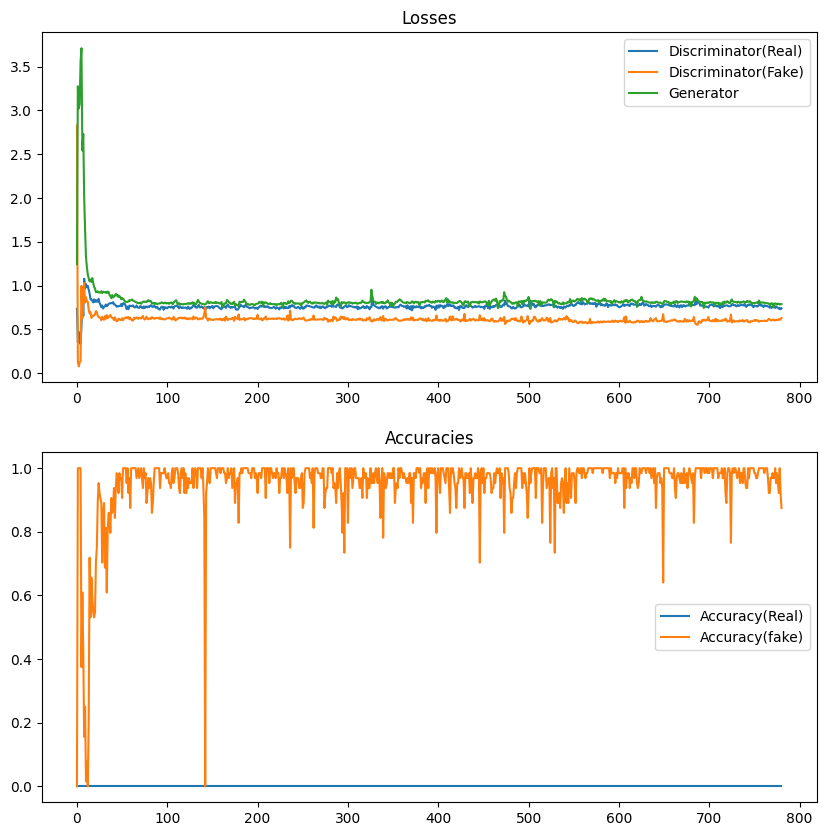

Iteration: 1
2/2 [==============================] - 0s 4ms/step
For Policy  [0.00157592 0.99842408]
313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 1.0
Probabilitity of starting position being 1: 0.0
Probability of action 0 being taken in state 0: 0.07796799404540379
Probability of action 1 being taken in state 0: 0.9145887606996651
Probability of action 2 being taken in state 1: 0.9996783962693967


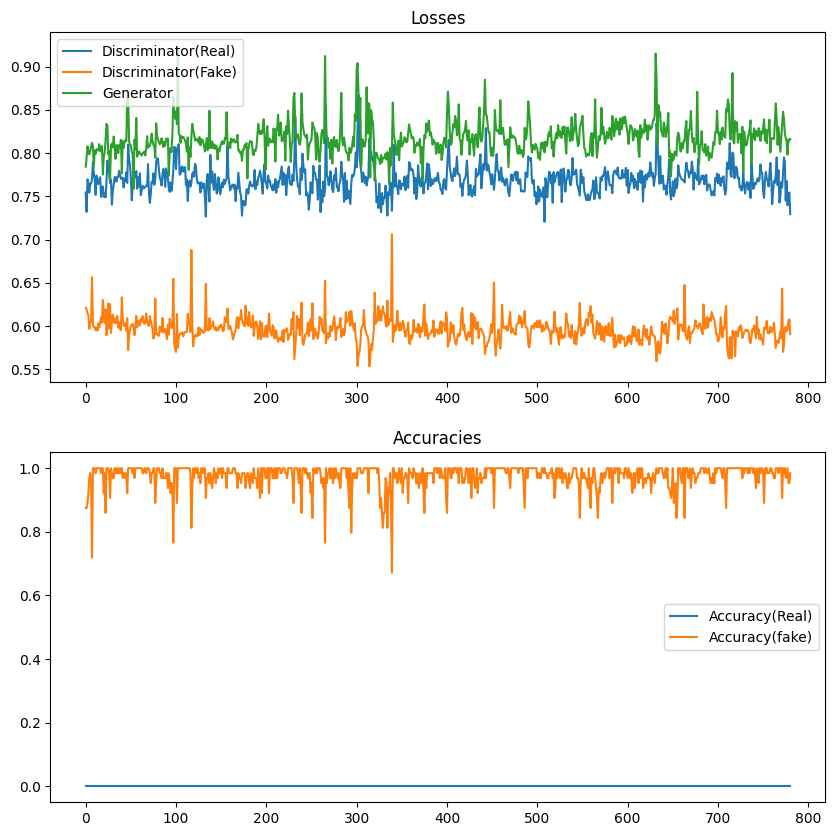

Iteration: 2
2/2 [==============================] - 0s 3ms/step
For Policy  [0.31072398 0.68927602]
313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 1.0
Probabilitity of starting position being 1: 0.0
Probability of action 0 being taken in state 0: 0.28987962550156043
Probability of action 1 being taken in state 0: 0.6989745876058849
Probability of action 2 being taken in state 1: 0.9995295224653022


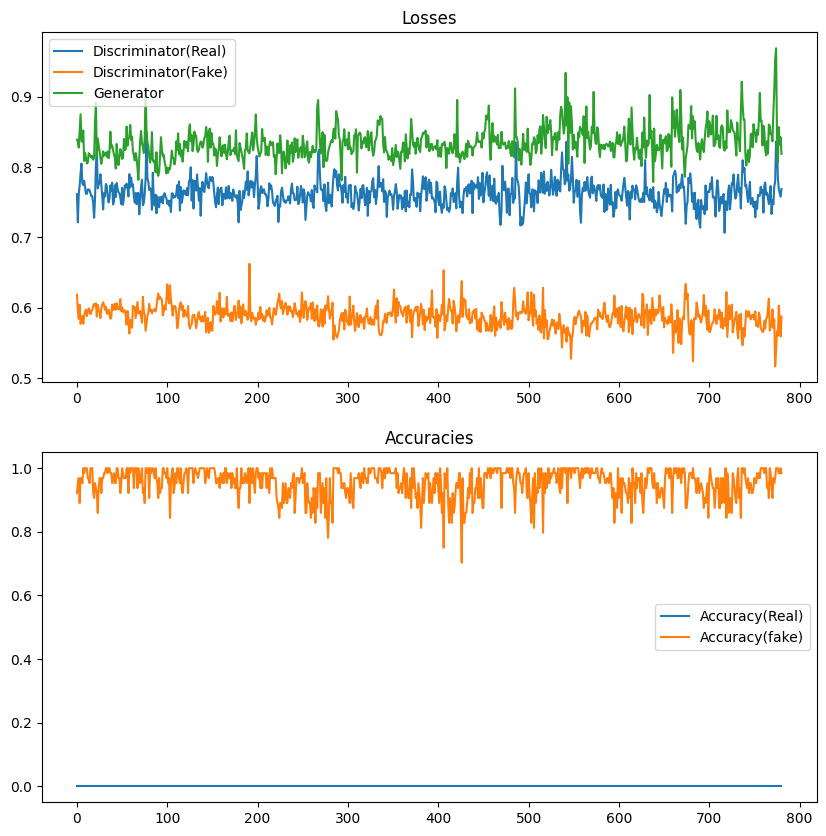

Iteration: 3
2/2 [==============================] - 0s 4ms/step
For Policy  [0.98057709 0.01942291]
313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 1.0
Probabilitity of starting position being 1: 0.0
Probability of action 0 being taken in state 0: 0.8491575674307614
Probability of action 1 being taken in state 0: 0.1495408200159086
Probability of action 2 being taken in state 1: 0.9987412003749033


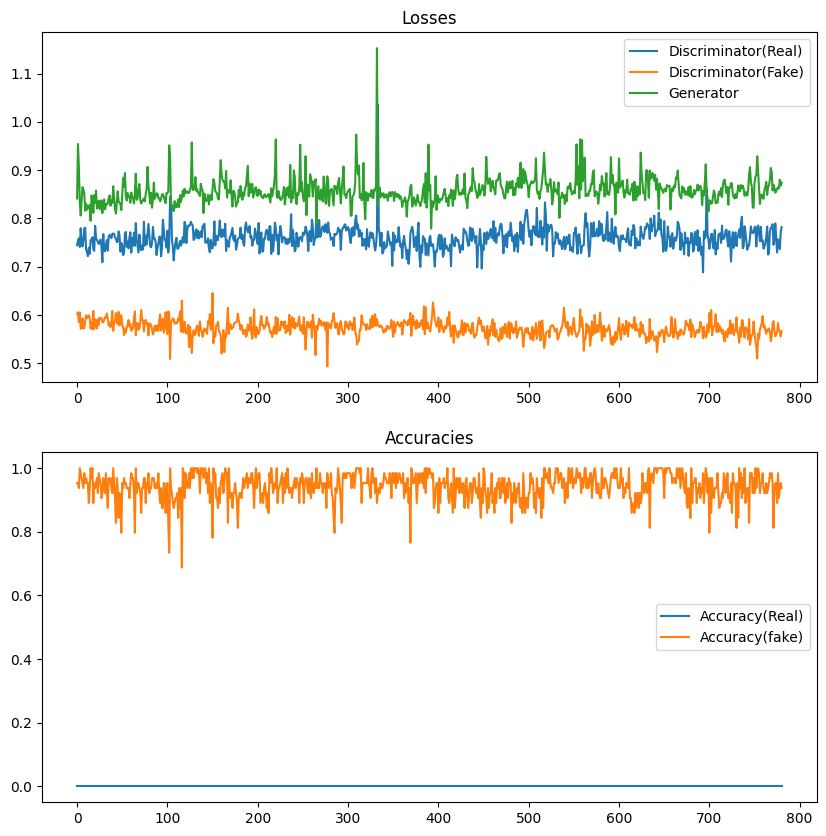

Iteration: 4
2/2 [==============================] - 0s 3ms/step
For Policy  [0.57480601 0.42519399]
313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 1.0
Probabilitity of starting position being 1: 0.0
Probability of action 0 being taken in state 0: 0.5448174424640941
Probability of action 1 being taken in state 0: 0.448780065755321
Probability of action 2 being taken in state 1: 0.9998315840530309


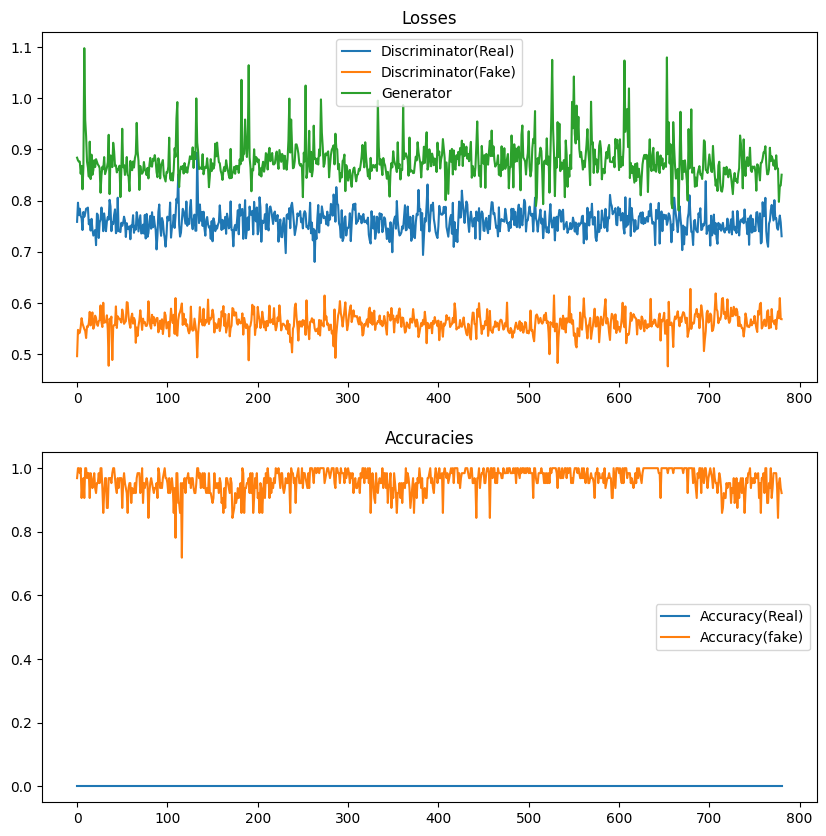

In [148]:
# tf.keras.config.disable_interactive_logging()
gan.train(epochs=5, batch_size=128, data_size=100000)

In [149]:
x, l, _ = gan.generate_real_samples(10)

In [150]:
gan.show_episode(x[2])

State: 0 Action: 0 Reward: 5.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0


In [151]:
labels = np.array([[0.5, 0.5] for _ in range(10)])
x, _ = gan.generate_fake_samples(10, labels)


1/1 [==============================] - 0s 30ms/step


In [152]:
# x = np.rint(x)
gan.show_episode(x[1])
# print(np.rint(x .[3]))
# gan.show_episode(np.rint(x[3]))


State: 0 Action: 1 Reward: 10.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0
State: 1 Action: 2 Reward: -1.0


In [164]:
labels = np.array([[0.3, 0.7] for _ in range(10000)])
gan.calculate_final_P(10000, labels)

313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 1.0
Probabilitity of starting position being 1: 0.0
Probability of action 0 being taken in state 0: 0.13359138972809667
Probability of action 1 being taken in state 0: 0.8597054380664653
Probability of action 2 being taken in state 1: 0.9999933069179696
[[[4.12014134e-01 5.87985866e-01]
  [9.88359324e-04 9.99011641e-01]
  [0.00000000e+00 1.00000000e+00]]

 [[0.00000000e+00 1.00000000e+00]
  [           nan            nan]
  [0.00000000e+00 1.00000000e+00]]]


/tmp/ipykernel_20386/845389626.py:126: RuntimeWarning: invalid value encountered in divide
  ps = ps / np.sum(ps, axis=2, keepdims=True)


In [123]:
# DO Q learning with real data online
import numpy as np

Q = np.zeros((2, 3))
gamma = 0.9
alpha = 0.01
epsilon = 0.1
for i in range(100000):
    current_state = 0
    while True:
        if np.random.uniform() < epsilon:
            action = np.random.choice([0, 1])
        else:
            action = np.argmax(Q[current_state])
        if current_state == 0:
            if action == 0:
                next_state = np.random.choice([0, 1])
                if next_state == 0:
                    reward = 5
                else:
                    reward = 5
            else:
                next_state = 1
                reward = 10
        else:
            action = 2
            next_state = 1
            reward = -1
        Q[current_state, action] = Q[current_state, action] + alpha * (
            reward + gamma * np.max(Q[next_state]) - Q[current_state, action]
        )
        current_state = next_state
        if current_state == 1:
            break
print(Q)

[[ 9.71698587 10.          0.        ]
 [ 0.          0.          0.        ]]


In [124]:
# Offline Q learning with real data
Q = np.zeros((2, 3))
gan = GAN()
real_data = gan.generate_real_samples(100000)[0]
for i in range(100000):
    current_state = 0
    for j in range(15):
        action = np.argmax(real_data[i, j, 2:5])
        next_state = np.argmax(real_data[i, j + 1, :2])
        reward = real_data[i, j, 5] * 11 - 1
        Q[current_state, action] = Q[current_state, action] + alpha * (
            reward + gamma * np.max(Q[next_state]) - Q[current_state, action]
        )
        current_state = next_state
        if current_state == 1:
            break
print(Q)

[[ 9.27342901 10.          0.        ]
 [ 0.          0.          0.        ]]


In [126]:
# Offline Q learning with fake data
Q = np.zeros((2, 3))
gan = GAN()
labels = np.array([[0.5, 0.5] for _ in range(100000)])
real_data = gan.generate_fake_samples(100000, labels)[0]
for i in range(100000):
    current_state = 0
    for j in range(15):
        action = np.argmax(real_data[i, j, 2:5])
        next_state = np.argmax(real_data[i, j + 1, :2])
        reward = (real_data[i, j, 5] * 11) - 1
        Q[current_state, action] = Q[current_state, action] + alpha * (
            reward + gamma * np.max(Q[next_state]) - Q[current_state, action]
        )
        current_state = next_state
        if current_state == 1:
            break
print(Q)

3125/3125 [==============================] - 5s 2ms/step
[[8.34970064 9.10685276 9.49342545]
 [0.         0.         0.        ]]


In [ ]:
# Offline Q learning with combined data
Q = np.zeros((2, 3))
gan = GAN()
labels = np.array([[1, 0] for _ in range(50000)])
real_data3 = np.array(gan.generate_fake_samples(50000, labels)[0])
real_data2 = np.array(gan.generate_real_samples(50000)[0])
print(type(real_data3), type(real_data2))
real_data = np.concatenate((real_data3,real_data2))
np.random.shuffle(real_data)
for i in range(100000):
    current_state = 0
    for j in range(15):
        action = np.argmax(real_data[i, j, 2:5])
        next_state = np.argmax(real_data[i, j + 1, :2])
        reward = (real_data[i, j, 5] * 11) - 1
        Q[current_state, action] = Q[current_state, action] + alpha * (
            reward + gamma * np.max(Q[next_state]) - Q[current_state, action]
        )
        current_state = next_state
        if current_state == 1:
            break
print(Q)

1563/1563 [==============================] - 4s 2ms/step
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
